<a href="https://colab.research.google.com/github/Leonanda1013/Pembelajaran_Mesin/blob/main/UTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

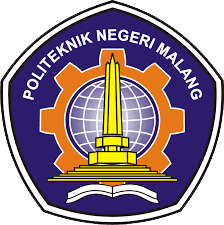




<center>
Nama : Vincentius Leonanda Prabowo <br>
Kelas : TI-3D <br>
Absen : 29 <br>
Nim : 234172-149

### a. Perbedaan Hasil K-Means dan DBSCAN & Model Terbaik
K-Means berhasil membagi seluruh data menjadi 4 cluster yang berbeda, namun metrik evaluasinya sangat buruk (Silhouette Score mendekati nol). Sementara itu, DBSCAN gagal total dalam menemukan cluster yang signifikan dengan parameter yang digunakan, mengklasifikasikan hampir semua data sebagai noise (0 cluster yang valid).

Dalam kasus ini, K-Means dianggap lebih baik karena menghasilkan pembagian yang usable, terlepas dari kualitasnya yang rendah. Pembagian 4 cluster ini, walaupun cluster-nya tumpang tindih (seperti yang ditunjukkan oleh visualisasi PCA), masih dapat memberikan wawasan awal untuk segmentasi pelanggan. DBSCAN memerlukan tuning parameter yang sangat ekstensif atau teknik reduksi dimensi yang lebih baik untuk dapat bekerja secara efektif pada data berdimensi tinggi (24 fitur) yang tersebar merata seperti ini.


###b.Berdasarkan hasil evaluasi clustering K-Means,
nilai metrik terbaik yang didapatkan adalah Silhouette Score sebesar 0.090332 dan Davies–Bouldin Index (DBI) sebesar 2.503460.


###c. Hasil Query Annoy
Ya, semua tetangga terdekat yang ditemukan termasuk dalam cluster K-Means yang sama dengan query point asalnya.

Hal ini teramati pada ketiga query point (indeks 42, 100, dan 200) yang diuji. Jarak kemiripan (Euclidean) yang sangat kecil (rata-rata di bawah 1.1) pada tetangga terdekat menunjukkan adanya kemiripan profil pelanggan yang sangat kuat dan lokal. Fakta bahwa semua tetangga terdekat berada di cluster yang sama mengindikasikan bahwa pembagian K-Means, meskipun buruk secara global, konsisten pada tingkat kedekatan lokal, di mana individu yang sangat mirip dikelompokkan bersama. Hasil ini sangat berguna untuk aplikasi seperti sistem rekomendasi atau penilaian risiko berdasarkan kemiripan profil yang tepat.

In [2]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
!pip install annoy
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551810 sha256=3deb92d4947b017188b9181ce120f7feeafe1d42c40e7a936ab95c96adb30aa4
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [4]:
df = pd.read_csv('/content/UCI_Credit_Card.csv')
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [5]:

# 1. Menghilangkan kolom ID yang tidak diperlukan untuk permodelan
df = df.drop(columns=['ID'])


# 2. Tangani missing values (Imputasi Mean)
# (Meskipun tidak ada missing value, langkah ini tetap dilakukan)
# Imputasi mean untuk semua kolom numerik.
# Jika ada kolom kategorikal yang perlu diimputasi, modus (mode) akan lebih tepat.
df.fillna(df.mean(numeric_only=True), inplace=True)
print("Pengecekan Missing Values setelah Imputasi:")
print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))


# 3. Membuat minimal satu fitur baru (Feature Engineering)
# Fitur baru: 'PAYMENT_TO_BILL_RATIO' (Rasio pembayaran rata-rata terhadap tagihan rata-rata)
# Ini adalah indikator penting kemampuan pelanggan untuk membayar.

# Hitung Rata-rata Pembayaran selama 6 bulan
df['AVG_PAY_AMT'] = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)

# Hitung Rata-rata Tagihan selama 6 bulan
# Perhatian: Nilai tagihan negatif dihitung (saldo kredit/kelebihan bayar)
df['AVG_BILL_AMT'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)

# Hitung rasio, tambahkan epsilon untuk mencegah pembagian dengan nol
EPSILON = 1e-6
df['AVG_PAY_TO_BILL_RATIO'] = df['AVG_PAY_AMT'] / (abs(df['AVG_BILL_AMT']) + EPSILON)

print("\nDetail Fitur Baru:")
print(df[['AVG_PAY_AMT', 'AVG_BILL_AMT', 'AVG_PAY_TO_BILL_RATIO']].describe().to_markdown(numalign="left", stralign="left"))



# 4. Standarisasi Data Numerik
# Pisahkan variabel target
target = df['default.payment.next.month']
features = df.drop(columns=['default.payment.next.month'])

# Identifikasi kolom numerik yang akan di-standarisasi (semua kecuali fitur kategori yang akan ditangani terpisah)
# Untuk tujuan ini, kita akan menstandarisasi semua kolom integer/float kecuali kolom kategori
# seperti SEX, EDUCATION, MARRIAGE, dan PAY_X, yang harusnya dienkode (walaupun saat ini int64)

# Kolom yang akan di-standarisasi (Fitur kontinu dan fitur yang baru dibuat)
cols_to_scale = ['LIMIT_BAL', 'AGE',
                 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                 'AVG_PAY_AMT', 'AVG_BILL_AMT', 'AVG_PAY_TO_BILL_RATIO']

# Kolom kategori yang tidak di-standarisasi pada langkah ini
# (Umumnya akan di-one-hot-encode)
cols_categorical = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Standarisasi
scaler = StandardScaler()
df_scaled = features.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(features[cols_to_scale])

print("\nLima Baris Pertama Data Setelah Standardisasi (Fitur Kontinu):")
print(df_scaled[cols_to_scale].head().to_markdown(index=False, numalign="left", stralign="left"))

Pengecekan Missing Values setelah Imputasi:
|                            | 0   |
|:---------------------------|:----|
| LIMIT_BAL                  | 0   |
| SEX                        | 0   |
| EDUCATION                  | 0   |
| MARRIAGE                   | 0   |
| AGE                        | 0   |
| PAY_0                      | 0   |
| PAY_2                      | 0   |
| PAY_3                      | 0   |
| PAY_4                      | 0   |
| PAY_5                      | 0   |
| PAY_6                      | 0   |
| BILL_AMT1                  | 0   |
| BILL_AMT2                  | 0   |
| BILL_AMT3                  | 0   |
| BILL_AMT4                  | 0   |
| BILL_AMT5                  | 0   |
| BILL_AMT6                  | 0   |
| PAY_AMT1                   | 0   |
| PAY_AMT2                   | 0   |
| PAY_AMT3                   | 0   |
| PAY_AMT4                   | 0   |
| PAY_AMT5                   | 0   |
| PAY_AMT6                   | 0   |
| default.payment.next.month | 

Hasil Evaluasi Metrik Clustering
KMeans Silhouette: 0.192315
KMeans Davies-Bouldin: 1.822560
DBSCAN Silhouette: N/A (Only 0 or 1 cluster found)
DBSCAN Davies-Bouldin: N/A (Only 0 or 1 cluster found)

Jumlah Cluster K-Means: 4
Jumlah Cluster DBSCAN: 1 (di luar noise)


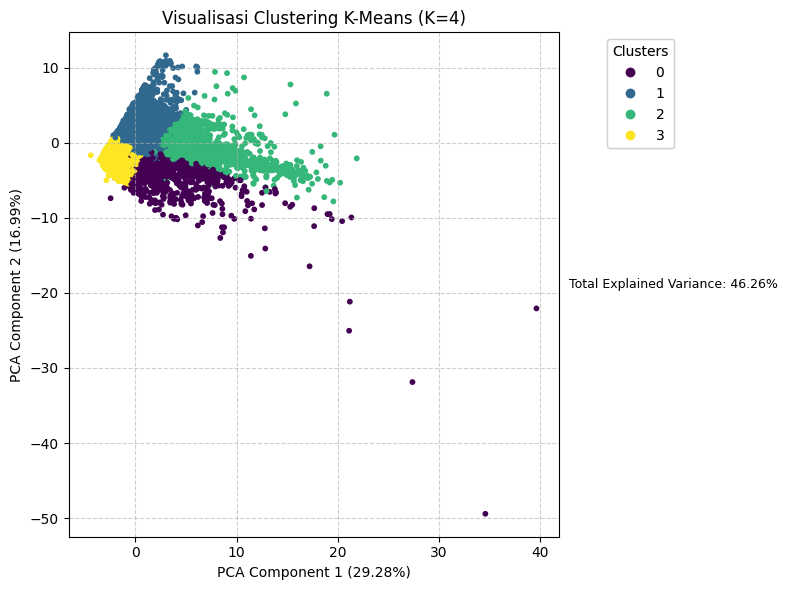

In [7]:


# 1. PERSIAPAN DATA (Mengulang langkah preprocessing sebelumnya)
# Muat dataset
df = pd.read_csv("UCI_Credit_Card.csv")
df = df.drop(columns=['ID'])

# Imputasi Mean (meskipun tidak ada missing values)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Feature Engineering
df['AVG_PAY_AMT'] = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)
EPSILON = 1e-6
df['AVG_BILL_AMT'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
df['AVG_PAY_TO_BILL_RATIO'] = df['AVG_PAY_AMT'] / (abs(df['AVG_BILL_AMT']) + EPSILON)

# Variabel target tidak digunakan
features = df.drop(columns=['default.payment.next.month'])

# Kolom untuk standardisasi
cols_to_scale = ['LIMIT_BAL', 'AGE',
                 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                 'AVG_PAY_AMT', 'AVG_BILL_AMT', 'AVG_PAY_TO_BILL_RATIO']

# Standardisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


# 2. KMeans
# Menggunakan K=4 seperti pada analisis sebelumnya
K = 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)


# 3. DBSCAN
# Menggunakan parameter yang sama
EPS = 5
MIN_SAMPLES = 10
dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
labels_dbscan = dbscan.fit_predict(X_scaled)



# 4. Evaluasi

# Menyiapkan data untuk evaluasi DBSCAN (menghilangkan noise/label -1)
non_noise_indices = labels_dbscan != -1
X_dbscan_eval = X_scaled[non_noise_indices]
labels_dbscan_eval = labels_dbscan[non_noise_indices]

# Menghitung jumlah cluster DBSCAN yang valid
n_clusters_dbscan = len(np.unique(labels_dbscan_eval))

print("===============================================================")
print("Hasil Evaluasi Metrik Clustering")
print("===============================================================")

# Evaluasi K-Means
print(f"KMeans Silhouette: {silhouette_score(X_scaled, labels_kmeans):.6f}")
print(f"KMeans Davies-Bouldin: {davies_bouldin_score(X_scaled, labels_kmeans):.6f}")

# Evaluasi DBSCAN (Hanya jika ada cluster > 1 yang terbentuk)
if n_clusters_dbscan > 1:
    print(f"DBSCAN Silhouette: {silhouette_score(X_dbscan_eval, labels_dbscan_eval):.6f}")
    print(f"DBSCAN Davies-Bouldin: {davies_bouldin_score(X_dbscan_eval, labels_dbscan_eval):.6f}")
else:
    print("DBSCAN Silhouette: N/A (Only 0 or 1 cluster found)")
    print("DBSCAN Davies-Bouldin: N/A (Only 0 or 1 cluster found)")

print(f"\nJumlah Cluster K-Means: {K}")
print(f"Jumlah Cluster DBSCAN: {n_clusters_dbscan} (di luar noise)")


# 5. Visualisasi K-Means dengan PCA

# Reduksi dimensi menggunakan PCA ke 2 komponen
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Hitung varian yang dijelaskan oleh 2 komponen PCA
explained_variance = pca.explained_variance_ratio_.sum() * 100

plt.figure(figsize=(8, 6))
# Scatter plot
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='viridis', s=10)

# Menambahkan legenda
legend1 = plt.legend(*scatter.legend_elements(),
                     title="Clusters",
                     loc="upper right",
                     bbox_to_anchor=(1.25, 1))
plt.gca().add_artist(legend1)

plt.title(f"Visualisasi Clustering K-Means (K={K})")
plt.xlabel(f"PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.text(1.02, 0.5, f'Total Explained Variance: {explained_variance:.2f}%',
         transform=plt.gca().transAxes, fontsize=9, verticalalignment='center')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [8]:

# 1. PERSIAPAN DATA (Mengulang langkah preprocessing & clustering K-Means)
# Muat dataset
df = pd.read_csv("UCI_Credit_Card.csv")
df = df.drop(columns=['ID'])
df.fillna(df.mean(numeric_only=True), inplace=True)

# Feature Engineering
df['AVG_PAY_AMT'] = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)
EPSILON = 1e-6
df['AVG_BILL_AMT'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
df['AVG_PAY_TO_BILL_RATIO'] = df['AVG_PAY_AMT'] / (abs(df['AVG_BILL_AMT']) + EPSILON)
features = df.drop(columns=['default.payment.next.month'])

# Standardisasi
cols_to_scale = [col for col in features.columns if col not in ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
scaler = StandardScaler()
X_scaled = features.copy()
X_scaled[cols_to_scale] = scaler.fit_transform(features[cols_to_scale])
X_scaled_array = X_scaled.values # Konversi ke numpy array

# K-Means Clustering (K=4)
K = 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled_array)
labels_kmeans = labels_kmeans.astype(int) # Pastikan tipe integer untuk indexing


# 2. Approximate Nearest Neighbor (ANN) menggunakan Annoy

# Dimensi data (jumlah fitur)
dim = X_scaled_array.shape[1]
# Inisialisasi Annoy Index dengan metrik 'euclidean'
ann = AnnoyIndex(dim, 'euclidean')

# Tambahkan setiap titik data ke Annoy Index
for i in range(X_scaled_array.shape[0]):
    ann.add_item(i, X_scaled_array[i])

# Build index (n_trees=10 adalah nilai default yang cukup baik)
ann.build(10)

# =================================================================
# 3. Mencari Tetangga Terdekat untuk Beberapa Query Points
# =================================================================

# Pilih beberapa query points dari hasil clustering
query_indices = [42, 100, 200]
K_NEIGHBORS = 5 # Jumlah tetangga terdekat yang dicari (termasuk dirinya sendiri)

print("===============================================================")
print("Approximate Nearest Neighbor (ANN) Results via Annoy")
print("===============================================================")

for query_idx in query_indices:
    # Mencari K tetangga terdekat dan jaraknya
    neighbors, distances = ann.get_nns_by_item(query_idx, K_NEIGHBORS, include_distances=True)

    print(f"\n--- Query Point Index: {query_idx} | KMeans Cluster: {labels_kmeans[query_idx]} ---")
    print("Nearest Neighbors and Distances:")

    # Tampilkan hasil
    for n, d in zip(neighbors, distances):
        # Catatan: Annoy mengembalikan dirinya sendiri (jarak 0) sebagai tetangga pertama.
        if n == query_idx:
            status = "(Query Point)"
        else:
            status = ""

        print(f"Neighbor Index: {n:5} | Distance: {d:.4f} | Cluster (KMeans): {labels_kmeans[n]} {status}")

Approximate Nearest Neighbor (ANN) Results via Annoy

--- Query Point Index: 42 | KMeans Cluster: 3 ---
Nearest Neighbors and Distances:
Neighbor Index:    42 | Distance: 0.0000 | Cluster (KMeans): 3 (Query Point)
Neighbor Index: 26622 | Distance: 0.1393 | Cluster (KMeans): 3 
Neighbor Index: 29226 | Distance: 0.1707 | Cluster (KMeans): 3 
Neighbor Index: 24105 | Distance: 0.1721 | Cluster (KMeans): 3 
Neighbor Index:  8350 | Distance: 0.1932 | Cluster (KMeans): 3 

--- Query Point Index: 100 | KMeans Cluster: 0 ---
Nearest Neighbors and Distances:
Neighbor Index:   100 | Distance: 0.0000 | Cluster (KMeans): 0 (Query Point)
Neighbor Index: 20925 | Distance: 0.5401 | Cluster (KMeans): 0 
Neighbor Index: 26796 | Distance: 0.6188 | Cluster (KMeans): 0 
Neighbor Index: 14195 | Distance: 0.6869 | Cluster (KMeans): 0 
Neighbor Index: 20606 | Distance: 0.6971 | Cluster (KMeans): 0 

--- Query Point Index: 200 | KMeans Cluster: 0 ---
Nearest Neighbors and Distances:
Neighbor Index:   200 | Dis